<a href="https://colab.research.google.com/github/kedarkotwal1/FraudJobDetection/blob/main/FakeJobPrediction_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import sys
import pandas as pd
import nltk
import numpy as np
import re
import io
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.width',None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/MyDrive

/content/drive/MyDrive


In [5]:
mydf = pd.read_csv('fake_job.csv')

In [124]:
print(mydf.head())

   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Foo

In [125]:
print(mydf.info())
print(mydf.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

# Creating a copy of mydf and storing it into jobdf

In [126]:
jobdf = mydf.copy()

In [127]:
print(jobdf.head(2))

   job_id                                      title          location  \
0       1                           Marketing Intern  US, NY, New York   
1       2  Customer Service - Cloud Video Production    NZ, , Auckland   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...    

#Percent of null values present in each feature

In [ ]:
total = jobdf.isnull().sum().sort_values(ascending=False)
percent_1 = jobdf.isnull().sum()/jobdf.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total','%'])
missing_data

#Total Null values in the dataset

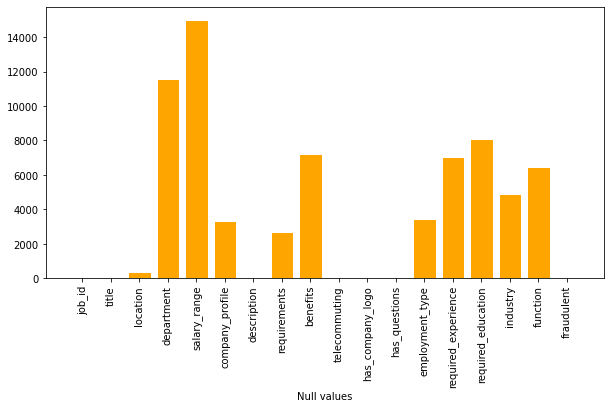

In [129]:
nullval = jobdf.isnull().sum()
plt.figure(figsize=(10,5))
plt.bar(jobdf.columns,nullval,color = 'orange', edgecolor = 'white')
plt.xlabel('Null values')
plt.xticks(rotation='vertical')
plt.show()

Same chart but horizontal

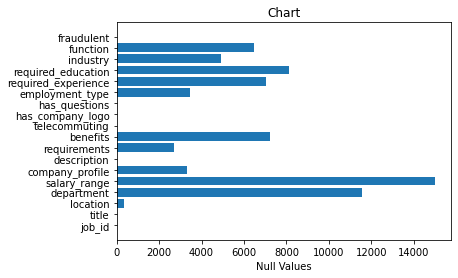

In [12]:
#plt.rcdefaults()
fig, ax = plt.subplots()
#plt.figure(figsize=(25,10))
ax.barh(jobdf.columns, nullval, align = 'center')
#ax.set_yticks(np.arange(mydf.columns))

#ax.invert_yaxes()
ax.set_xlabel('Null Values')
ax.set_title('Chart')
plt.show()



Distribution of Fraud and Non-fraud job adverts

In [130]:
jobdf['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [42]:
jobdf[jobdf['job_id']==15064]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,desc_len
15063,15064,Beauty & Fragrance consultants needed,"GB, , Belfast",NaN,NaN,Established on the principles that full time e...,Luxury beauty &amp; fragrance consultants need...,NaN,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,91


In [131]:
jobdf[jobdf['job_id']==15064]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
15063,15064,Beauty & Fragrance consultants needed,"GB, , Belfast",NaN,NaN,Established on the principles that full time e...,Luxury beauty &amp; fragrance consultants need...,NaN,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


#Finding word length count of company_profile, job description, requirements, benefits.

In [132]:
print(jobdf['company_profile'].iloc[2])

Valor Services provides Workforce Solutions that meet the needs of companies across the Private Sector, with a special focus on the Oil &amp; Gas Industry. Valor Services will be involved with you throughout every step of the hiring process and remain in contact with you all the way through the final step of signing of the employment contract with your new employer. Valor Services was founded with the vision of employing the unique skills, experiences, and qualities of America’s finest veterans to provide Private Sector companies with precise and concerted value-added services – and America’s finest Veterans with an optimized career opportunity.We are eager to get the word out to veterans that there are ample opportunities for employment in the private sector and that you are the ideal candidates to fill those positions. Valor Services Your Success is Our Mission. ™ 


In [133]:
#print(mydf['required_education'].unique())
function = lambda x:len(x.split(' '))

len_compprof = jobdf['company_profile'].astype(str).apply(function)
len_desc = jobdf['description'].astype(str).apply(function)
len_req = jobdf['requirements'].astype(str).apply(function)
len_benefits = jobdf['benefits'].astype(str).apply(function)

print(len_compprof.head())
print(len_desc.head())
print(len_req.head())
print(len_benefits.head())

jobdf['compprof_len'] = len_compprof
jobdf['desc_len'] = len_desc
jobdf['req_len'] = len_req
jobdf['benefits_len'] = len_benefits


0    141
1    150
2    136
3     85
4    205
Name: company_profile, dtype: int64
0    124
1    309
2     50
3    345
4    182
Name: description, dtype: int64
0    115
1    187
2    164
3    174
4     89
Name: requirements, dtype: int64
0      1
1    225
2      1
3     96
4      3
Name: benefits, dtype: int64


In [134]:
print(jobdf.head(10))

   job_id                                      title               location  \
0       1                           Marketing Intern       US, NY, New York   
1       2  Customer Service - Cloud Video Production         NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)          US, IA, Wever   
3       4          Account Executive - Washington DC     US, DC, Washington   
4       5                        Bill Review Manager     US, FL, Fort Worth   
5       6                           Accounting Clerk               US, MD,    
6       7                      Head of Content (m/f)         DE, BE, Berlin   
7       8           Lead Guest Service Specialist     US, CA, San Francisco   
8       9                                 HP BSM SME      US, FL, Pensacola   
9      10    Customer Service Associate - Part Time         US, AZ, Phoenix   

   department salary_range                                    company_profile  \
0   Marketing          NaN  We're Food52, and we'

Retrieve job advert with desc_len 2074

In [ ]:
print(jobdf[jobdf['desc_len']==2074])

Display description of the job advert with maximum description word count

In [ ]:
print(jobdf[jobdf['desc_len']==2074].description)
print("\n")
print("job advert with maximum word count", jobdf['desc_len'].max())
#jobdf['desc_len'].loc[:,201]

#Utilizing NA values in columns. Create new columns like no_description,no_benefits,no_companyProfile, etc. and put 1 if true.

Replacing benefits NaN values by 'empty'

In [135]:
jobdf['company_profile'].fillna('empty',inplace=True)
jobdf['requirements'].fillna('empty',inplace=True)
jobdf['description'].fillna('empty',inplace=True)
jobdf['benefits'].fillna('empty',inplace=True)

In [ ]:
print(jobdf.head())

Creating new column empty_benefits, empty_desc, empty_compprof having value as 1 or 0.

In [136]:
checkNA = lambda x: 1 if x=='empty' else 0

empty_compprof = pd.DataFrame(jobdf['company_profile'].astype(str).apply(checkNA))
empty_desc = pd.DataFrame(jobdf['description'].astype(str).apply(checkNA))
empty_req = pd.DataFrame(jobdf['requirements'].astype(str).apply(checkNA))
empty_benefits = pd.DataFrame(jobdf['benefits'].astype(str).apply(checkNA))


# print(empty_benefits.value_counts())
# print(empty_benefits[:10])

actually creating columns.

In [137]:
jobdf['empty_compprof'] = empty_compprof
jobdf['empty_desc'] = empty_desc
jobdf['empty_req'] = empty_req
jobdf['empty_benefits'] = empty_benefits



In [138]:
print(jobdf[30:50])

    job_id                                              title  \
30      31             Customer Service Technical Specialist    
31      32                   Software Applications Specialist   
32      33                                Craftsman Associate   
33      34                                Completion Engineer   
34      35                        I Want To Work At Karmarama   
35      36                            English Teacher Abroad    
36      37                 Graduates: English Teacher Abroad    
37      38                                    PROJECT MANAGER   
38      39                                       Art Director   
39      40  Receptionist/Customer Service Technical Specia...   
40      41                            English Teacher Abroad    
41      42                            English Teacher Abroad    
42      43                                      Jr. Developer   
43      44           Customer Service Associate Receptionist    
44      45               

#Seaborn countplot showing most desired required education in job adverts.(Without considering NA values.

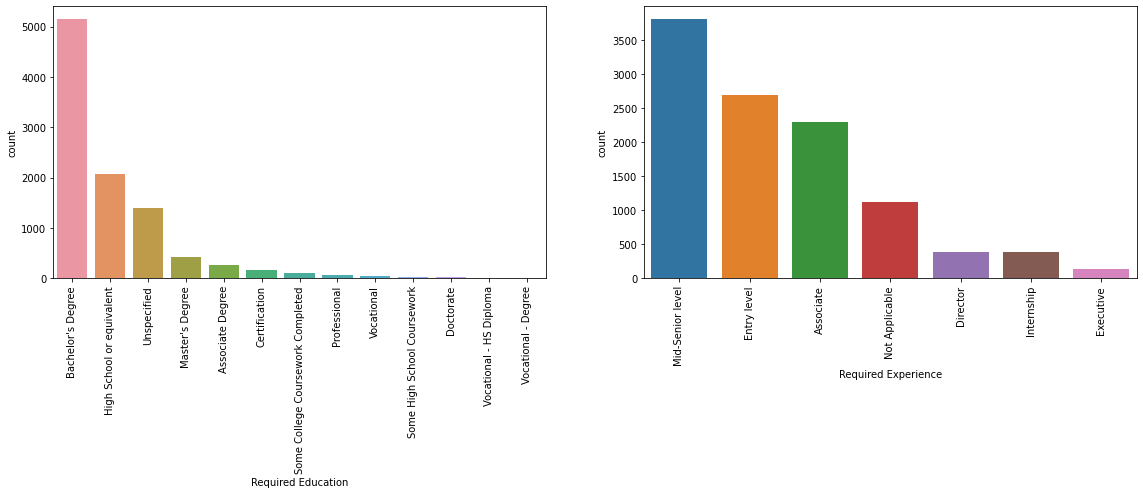

In [140]:
plt.figure(figsize=(30,5))
fig1 = plt.subplot(1,3,1)
ax1 = sns.countplot(x=jobdf['required_education'].astype(str), data=jobdf['required_education'], order = jobdf['required_education'].value_counts().index)
plt.setp(ax1.get_xticklabels(), rotation=90)
plt.xlabel('Required Education')

fig2 = plt.subplot(1,3,2)
ax2 = sns.countplot(x=jobdf['required_experience'].astype(str),  data=jobdf['required_experience'], order = jobdf['required_experience'].value_counts().index)
plt.setp(ax2.get_xticklabels(), rotation = 90)
plt.xlabel('Required Experience')

plt.show()

Most popular fields and most popular employment type.

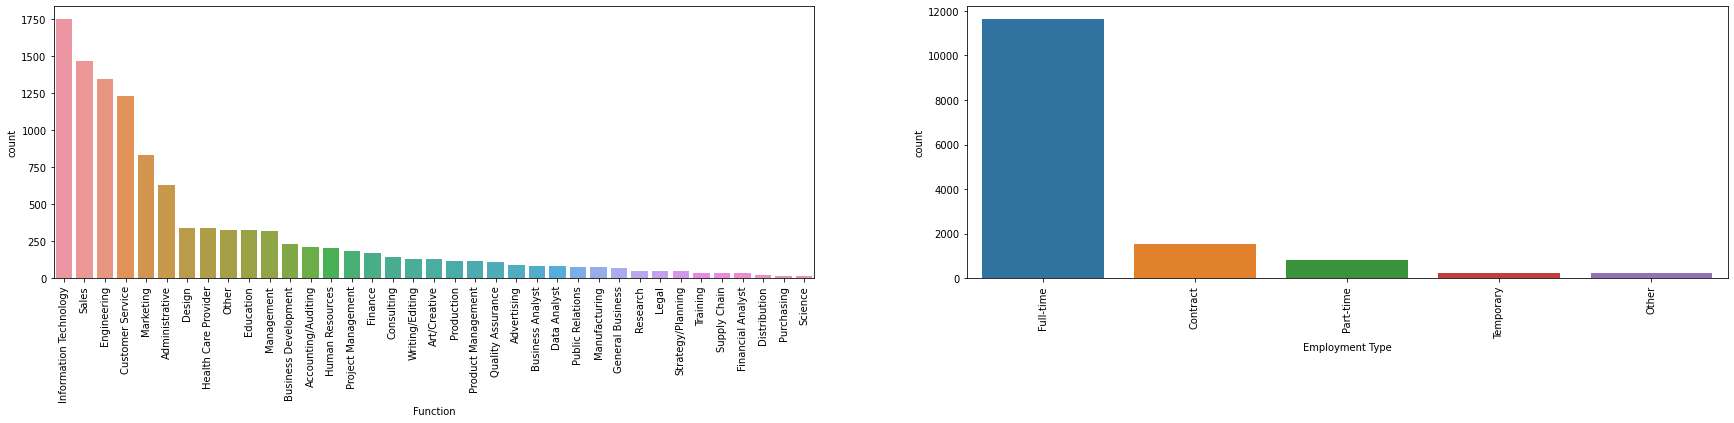

In [141]:
# fig, ax = plt.subplots()
plt.figure(figsize=(30,5))
#fig,axes = plt.subplots(1,3, figsize=(15,5))
fig1 = plt.subplot(1,2,1)
ax=sns.countplot(x=jobdf['function'].astype(str), data=jobdf, order = jobdf['function'].value_counts().index)
#plt.xticks(rotation='vertical')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel('Function')

fig3 = plt.subplot(1,2,2)
ax3 = sns.countplot(x=jobdf['employment_type'].astype(str), data=jobdf, order = jobdf['employment_type'].value_counts().index)
plt.setp(ax3.get_xticklabels(), rotation = 90)
plt.xlabel('Employment Type')

plt.show()

#Trial

In [ ]:
plt.figure(figsize=(25,20))
plt.subplot(3,3,1)
plt.plot(jobdf['required_education'].astype(str), color = 'red')
plt.xlabel('REQ EDU')
plt.xticks(rotation='vertical')

plt.subplot(3,3,2)
plt.hist(jobdf['required_experience'].astype(str), color = 'yellow', edgecolor = 'black', )
plt.xlabel('REQ EXP')
plt.xticks(rotation='vertical')

plt.subplot(3,3,3)
plt.hist(jobdf['function'].astype(str), color = 'blue', edgecolor = 'black', )
plt.xlabel('Location')
plt.xticks(rotation='vertical')


plt.show()

In [ ]:
jobdf['location'].isna().sum()

346

#Plotting the length of fraud and non_fraud job adverts.

<class 'pandas.core.frame.DataFrame'>


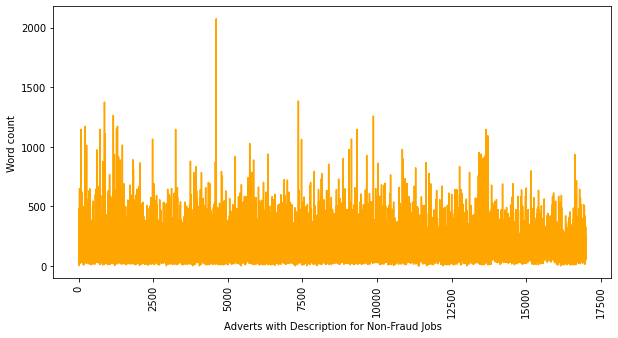

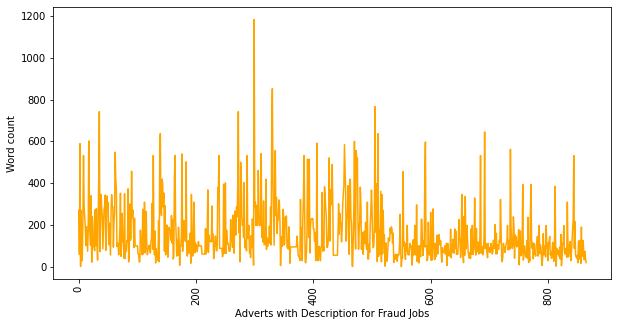

In [142]:
desc_fraud = pd.DataFrame(jobdf[jobdf['fraudulent']==1].desc_len)
#print(desc_fraud)

desc_nonfraud = pd.DataFrame(jobdf[jobdf['fraudulent']==0].desc_len)
print(type(desc_nonfraud))
desc_fraud.reset_index(drop=True,inplace=True)
desc_nonfraud.reset_index(drop=True,inplace=True)

plt.figure(figsize=(10,5))
plt.plot(desc_nonfraud, color = 'orange')
plt.ylabel('Word count')
plt.xlabel('Adverts with Description for Non-Fraud Jobs')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(desc_fraud, color = 'orange')
plt.ylabel('Word count')
plt.xlabel('Adverts with Description for Fraud Jobs')
plt.xticks(rotation='vertical')
plt.show()


<class 'pandas.core.frame.DataFrame'>


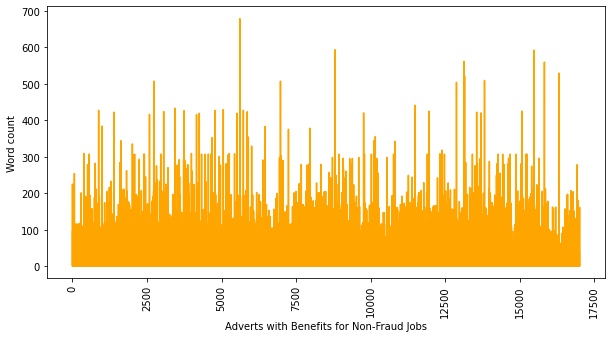

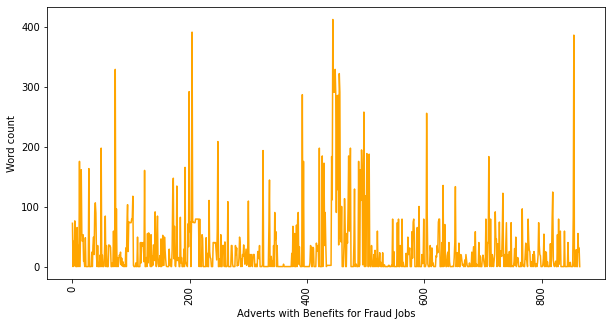

In [143]:
benefits_fraud = pd.DataFrame(jobdf[jobdf['fraudulent']==1].benefits_len)
#print(desc_fraud)

benefits_nonfraud = pd.DataFrame(jobdf[jobdf['fraudulent']==0].benefits_len)
print(type(benefits_nonfraud))
benefits_fraud.reset_index(drop=True,inplace=True)
benefits_nonfraud.reset_index(drop=True,inplace=True)

plt.figure(figsize=(10,5))
plt.plot(benefits_nonfraud, color = 'orange')
plt.ylabel('Word count')
plt.xlabel('Adverts with Benefits for Non-Fraud Jobs')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(benefits_fraud, color = 'orange')
plt.ylabel('Word count')
plt.xlabel('Adverts with Benefits for Fraud Jobs')
plt.xticks(rotation='vertical')
plt.show()

<class 'pandas.core.frame.DataFrame'>


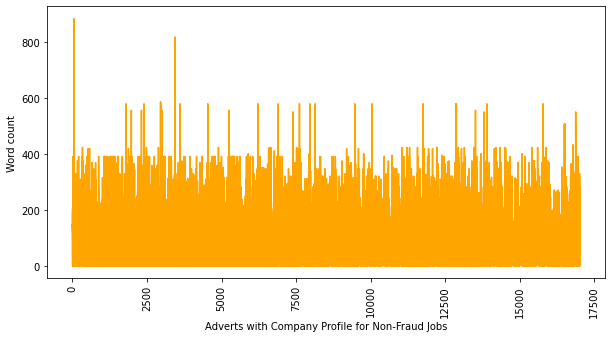

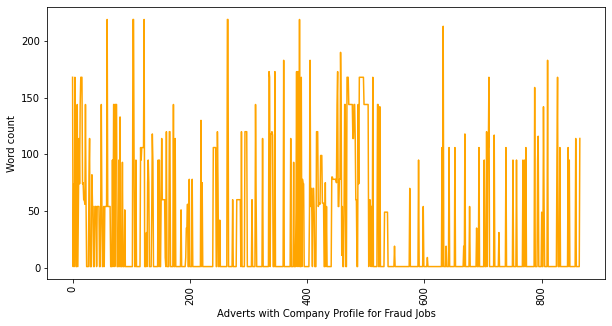

In [144]:
compprof_fraud = pd.DataFrame(jobdf[jobdf['fraudulent']==1].compprof_len)
#print(desc_fraud)

compprof_nonfraud = pd.DataFrame(jobdf[jobdf['fraudulent']==0].compprof_len)
print(type(compprof_nonfraud))
compprof_fraud.reset_index(drop=True,inplace=True)
compprof_nonfraud.reset_index(drop=True,inplace=True)

plt.figure(figsize=(10,5))
plt.plot(compprof_nonfraud, color = 'orange')
plt.ylabel('Word count')
plt.xlabel('Adverts with Company Profile for Non-Fraud Jobs')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(compprof_fraud, color = 'orange')
plt.ylabel('Word count')
plt.xlabel('Adverts with Company Profile for Fraud Jobs')
plt.xticks(rotation='vertical')
plt.show()

In [145]:
print("NonFraud job advert with maximum Description word count", desc_nonfraud.max())
print("NonFraud job advert with maximum Benefits word count", benefits_nonfraud.max())
print("NonFraud job advert with maximum Company Profile word count", compprof_nonfraud.max())

print("NonFraud job advert with minimum Description word count", desc_nonfraud.min())
print("NonFraud job advert with minimum Benefits word count", benefits_nonfraud.min())
print("NonFraud job advert with minimum Company Profile word count", compprof_nonfraud.min())

print("NonFraud job advert with average Description word count", desc_nonfraud.mean())
print("NonFraud job advert with average Benefits word count", benefits_nonfraud.mean())
print("NonFraud job advert with average Company Profile word count", compprof_nonfraud.mean())


print("Fraud job advert with maximum Description word count", desc_fraud.max())
print("Fraud job advert with maximum Benefits word count", benefits_fraud.max())
print("Fraud job advert with maximum Company Profile word count", compprof_fraud.max())

print("Fraud job advert with minimum Description word count", desc_fraud.min())
print("Fraud job advert with minimum Benefits word count", benefits_fraud.min())
print("Fraud job advert with minimum Company Profile word count", compprof_fraud.min())

print("Fraud job advert with average Description word count", desc_fraud.mean())
print("Fraud job advert with average Benefits word count", benefits_fraud.mean())
print("Fraud job advert with average Company Profile word count", compprof_fraud.mean())

NonFraud job advert with maximum Description word count desc_len    2074
dtype: int64
NonFraud job advert with maximum Benefits word count benefits_len    678
dtype: int64
NonFraud job advert with maximum Company Profile word count compprof_len    884
dtype: int64
NonFraud job advert with minimum Description word count desc_len    1
dtype: int64
NonFraud job advert with minimum Benefits word count benefits_len    1
dtype: int64
NonFraud job advert with minimum Company Profile word count compprof_len    1
dtype: int64
NonFraud job advert with average Description word count desc_len    171.043552
dtype: float64
NonFraud job advert with average Benefits word count benefits_len    30.400846
dtype: float64
NonFraud job advert with average Company Profile word count compprof_len    94.941578
dtype: float64
Fraud job advert with maximum Description word count desc_len    1183
dtype: int64
Fraud job advert with maximum Benefits word count benefits_len    412
dtype: int64
Fraud job advert with 

#This is wrong. Merged dataframe is only having 866 rows, 17k+ rows of nonfraud jobs desc is missing

In [ ]:
len_description_merged = pd.DataFrame(columns=['DescriptionFraud','DescriptionNonFraud'])
len_description_merged['DescriptionFraud'] = desc_fraud
len_description_merged['DescriptionNonFraud'] = desc_nonfraud
print(len_description_merged.head())
print(desc_fraud.shape)
print(desc_nonfraud.shape)
print(len_description_merged.shape)


   DescriptionFraud  DescriptionNonFraud
0               270                  124
1                59                  309
2               589                   50
3                 2                  345
4               270                  182
(866, 1)
(17014, 1)
(866, 2)


#Job Description word count plotted for fraud jobs and non-fraud jobs

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text major ticklabel objects>)

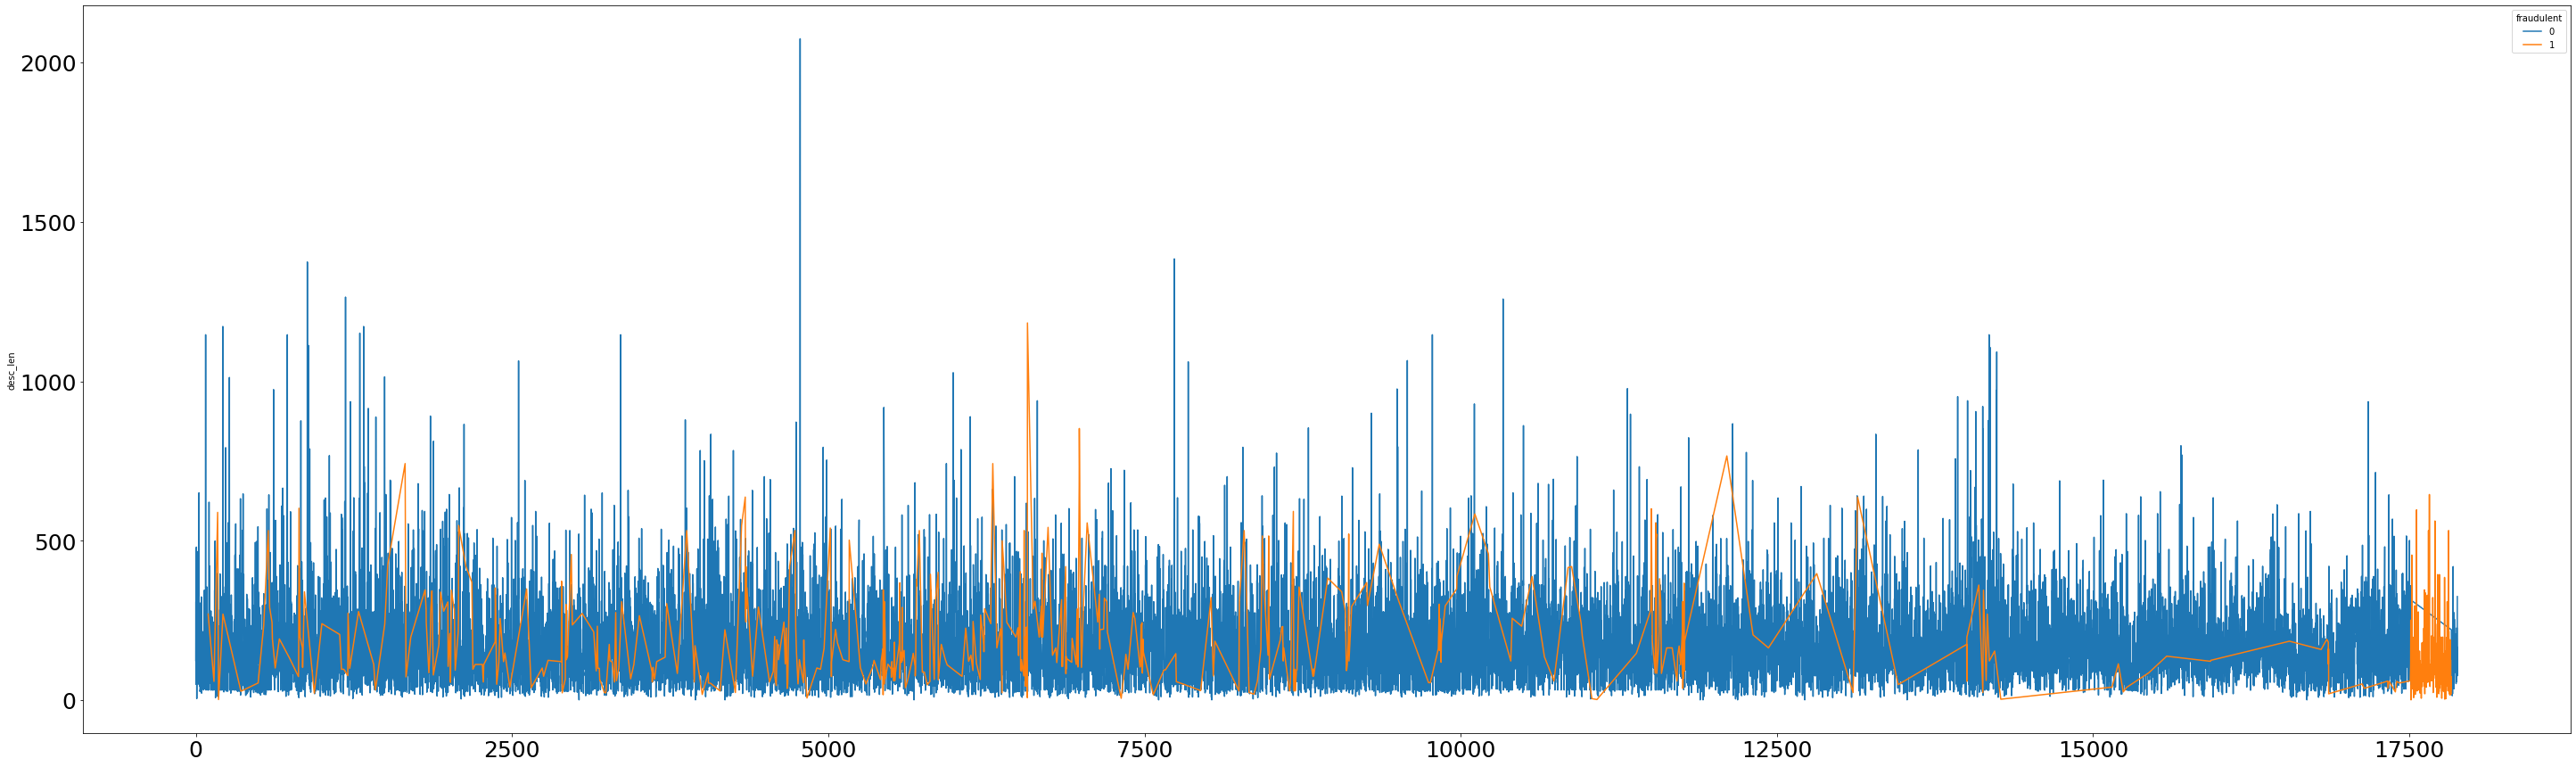

In [146]:
from numpy.ma.core import size
plt.figure(figsize = (50,15))
sns.lineplot(x=jobdf.index, y=jobdf['desc_len'], hue=jobdf['fraudulent'], data = jobdf)
plt.xticks(size=25)
plt.yticks(size=25)

In [147]:
print(desc_fraud['desc_len'].max())
print(desc_nonfraud['desc_len'].max())

1183
2074


6575    6576
Name: job_id, dtype: int64
1183


#KEEPING THIS UNEDITED